In [1]:
import pandas as pd

# Load your dataset
file_path = 'D:\Thesis_Code\suicide_detection_final_cleaned.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(df.head())


                                                text        class  \
0  Ex Wife Threatening SuicideRecently I left my ...      suicide   
1  Am I weird I don't get affected by compliments...  non-suicide   
2  Finally 2020 is almost over... So I can never ...  non-suicide   
3          i need helpjust help me im crying so hard      suicide   
4   It ends tonight.I can’t do it anymore. \nI quit.      suicide   

                                        cleaned_text  
0  sex wife threaten suicide recently leave wife ...  
1  weird not affect compliment come know girl fee...  
2   finally hear bad year swear fucking god annoying  
3                            need help help cry hard  
4                       end tonight not anymore quit  


In [2]:
df_copy=df.copy()

In [5]:
df=df_copy

In [6]:
df_2=df.drop(columns=['text'])

In [7]:
df_2

,class,cleaned_text
0,suicide,sex wife threaten suicide recently leave wife ...
1,non-suicide,weird not affect compliment come know girl fee...
2,non-suicide,finally hear bad year swear fucking god annoying
3,suicide,need help help cry hard
4,suicide,end tonight not anymore quit
...,...,...
175649,non-suicide,today went sled friend not like pretty big mil...
175650,non-suicide,not like rock not go
175651,non-suicide,tell friend not lonely deprive buy little nigh...
175652,non-suicide,pee probably taste like salty tea drink pee co...


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load pre-trained model and tokenizer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [9]:
def get_emotion_percentages(text, tokenizer, model, device):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits (raw predictions)
    logits = outputs.logits

    # Convert logits to probabilities
    probs = F.softmax(logits, dim=-1).cpu().numpy()[0]

    # Define the emotion labels
    emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

    # Calculate the percentage of each emotion
    emotion_percentages = {emotions[i]: probs[i] * 100 for i in range(len(emotions))}

    return emotion_percentages


In [10]:
def process_text(row, tokenizer, model, device):
    text = row['text']
    emotions = get_emotion_percentages(text, tokenizer, model, device)
    negative_emotion_sum = emotions['sadness'] + emotions['anger'] + emotions['fear']
    return negative_emotion_sum

In [11]:
# Apply the function to each row in the dataframe
df_2['negative_emotion_sum'] = df.apply(lambda row: process_text(row, tokenizer, model, device), axis=1)

# Display the dataframe with the new column
print(df_2.head())

         class                                       cleaned_text  \
0      suicide  sex wife threaten suicide recently leave wife ...   
1  non-suicide  weird not affect compliment come know girl fee...   
2  non-suicide   finally hear bad year swear fucking god annoying   
3      suicide                            need help help cry hard   
4      suicide                       end tonight not anymore quit   

   negative_emotion_sum  
0              0.586264  
1             90.922198  
2             31.470199  
3              0.738998  
4             30.418788  


In [25]:
df_2.describe

<bound method NDFrame.describe of               class                                       cleaned_text  \
0           suicide  sex wife threaten suicide recently leave wife ...   
1       non-suicide  weird not affect compliment come know girl fee...   
2       non-suicide   finally hear bad year swear fucking god annoying   
3           suicide                            need help help cry hard   
4           suicide                       end tonight not anymore quit   
...             ...                                                ...   
175649  non-suicide  today went sled friend not like pretty big mil...   
175650  non-suicide                               not like rock not go   
175651  non-suicide  tell friend not lonely deprive buy little nigh...   
175652  non-suicide  pee probably taste like salty tea drink pee co...   
175653  non-suicide  not beat boss hollow knight fight time die ear...   

        negative_emotion_sum  
0                   0.586264  
1              

In [32]:
# Filter the DataFrame
filtered_df = df_2[(df_2['class'] == 'suicide') & (df_2['negative_emotion_sum'] == 0 )]


In [33]:
filtered_df

,class,cleaned_text,negative_emotion_sum


In [38]:
plt.style.use('Solarize_Light2')

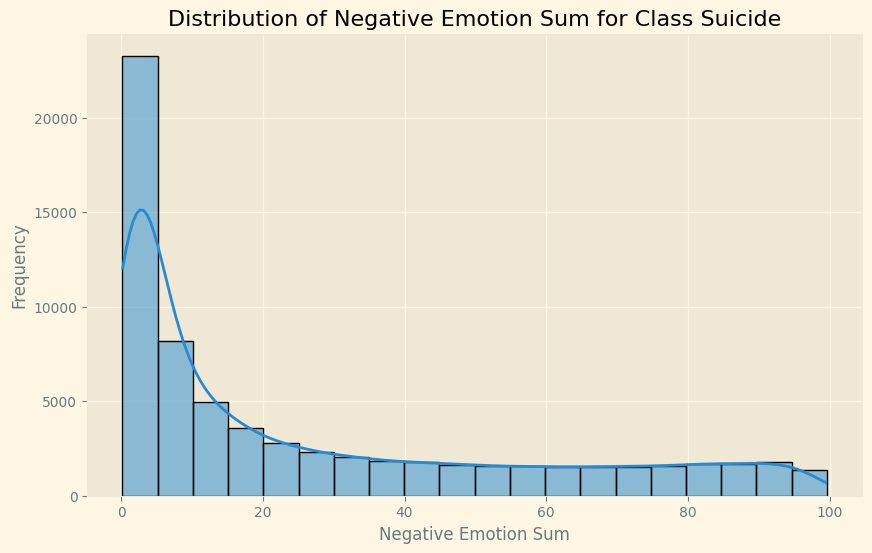

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame for class 1
class_1_df = df_2[df_2['class'] == 'suicide']

# Plot a histogram
plt.figure(figsize=(10, 6))
sns.histplot(class_1_df['negative_emotion_sum'], bins=20, kde=True)
plt.title('Distribution of Negative Emotion Sum for Class Suicide')
plt.xlabel('Negative Emotion Sum')
plt.ylabel('Frequency')
plt.show()


C:\Users\shari\AppData\Local\Temp\ipykernel_20892\1302862106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_1_df['text_length'] = class_1_df['cleaned_text'].apply(len)


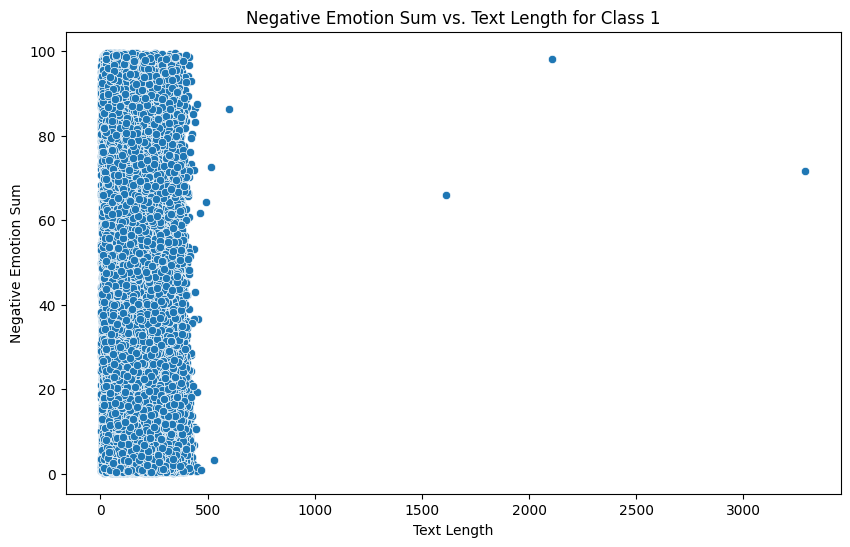

In [35]:
# Create a new column for the length of cleaned_text
class_1_df['text_length'] = class_1_df['cleaned_text'].apply(len)

# Plot a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='negative_emotion_sum', data=class_1_df)
plt.title('Negative Emotion Sum vs. Text Length for Class 1')
plt.xlabel('Text Length')
plt.ylabel('Negative Emotion Sum')
plt.show()


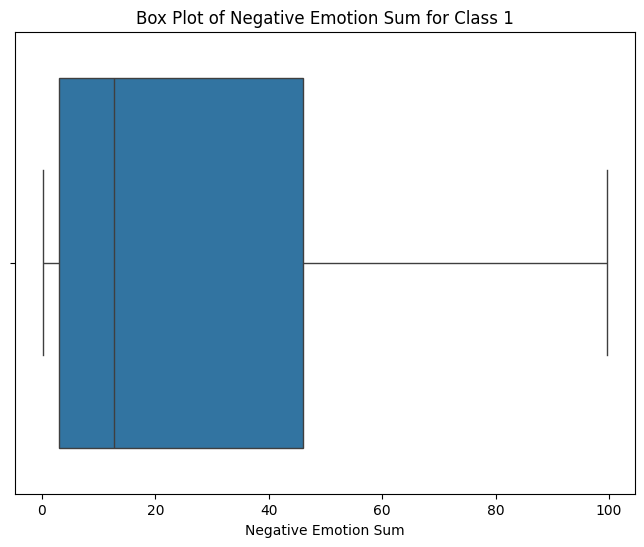

In [36]:
# Plot a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=class_1_df['negative_emotion_sum'])
plt.title('Box Plot of Negative Emotion Sum for Class 1')
plt.xlabel('Negative Emotion Sum')
plt.show()


In [11]:
MODEL_SAVE_PATH = "Models/emotion"
torch.save(model.state_dict(), 'MODEL_SAVE_PATH')
 